In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer

from sklearn.manifold import TSNE

In [3]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet2 import OldGraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from core.EmbeddingDataSet import EmbeddingDataSet
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.evaluation_metrics import evaluate_net_metrics, evaluate_embedding_metrics
from core.DimReduction import DimReduction

In [4]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [5]:
dataset_name = 'cora'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir)
dataset.create_all_train_data(shuffle=True)
dataset.summarise()

Name of dataset = cora
Input dimension = 1433
Number of training samples = 2708
Training labels = True
Graph information = True


In [6]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers

In [7]:
# Graph net
net_1 = OldGraphConvNet2(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/cora_3/'
filename = root + 'graph_net_502.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])
net_1.eval()

trust, one_nn, five_nn, time_elapsed = evaluate_net_metrics(dataset.all_train_data, net_1, 'cosine')
print("Trustworthy score = {:.4f}".format(trust))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.7929
1-NN generalisation accuracy = 0.5729
5-NN generalisation accuracy = 0.6144
Average time to compute (s) = 0.01


In [8]:
# Graph net
net_2 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/cora_5/'
filename = root + 'simple_net_1000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])
net_2.eval()

trust, one_nn, five_nn, time_elapsed = evaluate_net_metrics(dataset.all_train_data, net_2, 'cosine')
print("Trustworthy score = {:.4f}".format(trust))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.8193
1-NN generalisation accuracy = 0.5822
5-NN generalisation accuracy = 0.6139
Average time to compute (s) = 0.01


In [9]:
# tSNE
embedder = TSNE(n_components=2, metric='cosine', method='exact', perplexity=30, verbose=0)

trust, one_nn, five_nn, time_elapsed = evaluate_embedding_metrics(dataset.all_train_data, embedder, 'cosine')
print("Trustworthy score = {:.4f}".format(trust))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.8408
1-NN generalisation accuracy = 0.5310
5-NN generalisation accuracy = 0.5129
Average time to compute (s) = 4.65


## Create visualisation

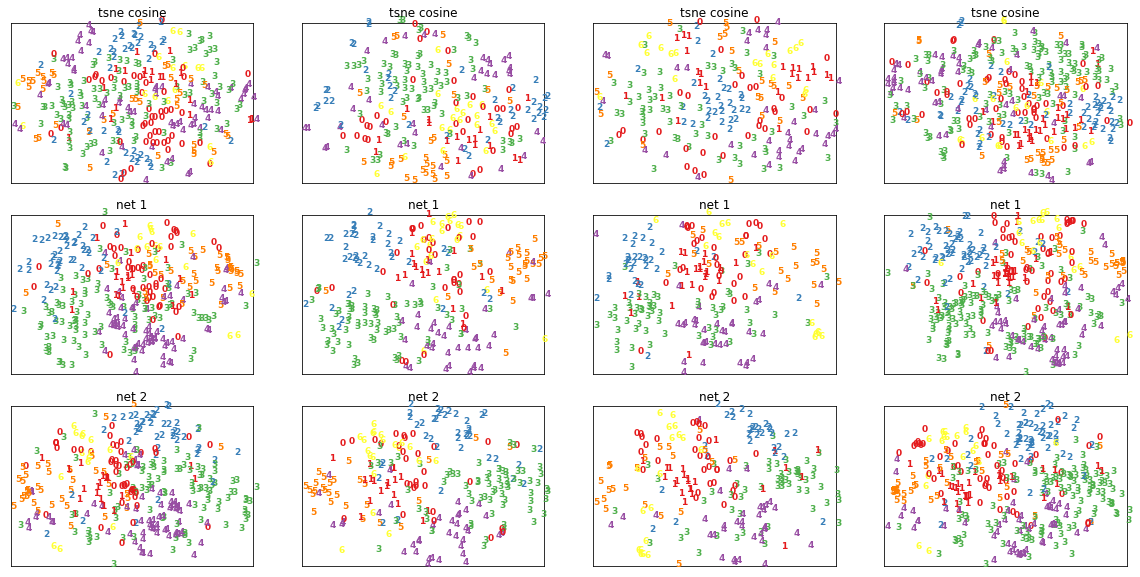

In [11]:
f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(20, 10))
dim_red = DimReduction(n_components=2)

for i in range(4):
    G = dataset.all_train_data[i]
    labels = [int(l) for l in G.labels]
    X = G.data.view(G.data.shape[0], -1).numpy()
    
#     # tsne
#     embedder = TSNE(n_components=2, metric='euclidean', method='exact', perplexity=30, verbose=0)
#     X_emb = embedder.fit_transform(X)
#     plot_embedding_subplot(axarr[0,i], X_emb, labels=labels, title='tsne')
    
    # tsne
    embedder = TSNE(n_components=2, metric='cosine', method='exact', perplexity=30, verbose=0)
    X_emb_cos = embedder.fit_transform(X)
    plot_embedding_subplot(axarr[0,i], X_emb_cos, labels=labels, title='tsne cosine')
    
    # Net
    if torch.cuda.is_available():   
        y_pred = net_1.forward(G).cpu().detach().numpy()
    else:    
        y_pred = net_1.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[1,i], y_pred, labels=labels, title='net 1')
    
    # Net
    if torch.cuda.is_available():   
        y_pred = net_2.forward(G).cpu().detach().numpy()
    else:    
        y_pred = net_2.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[2,i], y_pred, labels=labels, title='net 2')


In [12]:
assert False

AssertionError: 

In [ ]:
G_all = DataEmbeddingGraph(dataset.inputs, dataset.labels, method=None, W=dataset.adj_matrix)

In [ ]:
time_start = timer()

if torch.cuda.is_available():   
    y_pred = net_1.forward(G_all).cpu().detach().numpy()
else:    
    y_pred = net_1.forward(G_all).detach().numpy()

time_elapsed = timer() - time_start

In [ ]:
from util.evaluation_metrics import trustworthiness, nearest_neighbours_generalisation_accuracy

In [ ]:
y_pred.shape

In [ ]:
trust_score = trustworthiness(dataset.inputs, y_pred, n_neighbors=5, metric='cosine')
one_nn_score = nearest_neighbours_generalisation_accuracy(y_pred, dataset.labels.numpy(), 1)
five_nn_score = nearest_neighbours_generalisation_accuracy(y_pred, dataset.labels.numpy(), 5)
print("Trustworthy score = {:.4f}".format(trust_score))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn_score))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn_score))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

In [ ]:
# Split dataset into batches
dataset.create_all_train_data(shuffle=False)
print(sum([len(G.labels) for G in dataset.all_train_data]))

In [ ]:
# Predict batch by batch
time_start = timer()

y_pred = np.zeros(y_pred.shape)
i = 0
for G in dataset.all_train_data:
    if torch.cuda.is_available():   
        y_pred_batch = net_1.forward(G).cpu().detach().numpy()
    else:    
        y_pred_batch = net_1.forward(G).detach().numpy()
    y_pred[i: i+len(G.labels)] = y_pred_batch
    i += len(G.labels)

time_elapsed = timer() - time_start

In [ ]:
trust_score = trustworthiness(dataset.inputs, y_pred, n_neighbors=5, metric='cosine')
one_nn_score = nearest_neighbours_generalisation_accuracy(y_pred, dataset.labels.numpy(), 1)
five_nn_score = nearest_neighbours_generalisation_accuracy(y_pred, dataset.labels.numpy(), 5)
print("Trustworthy score = {:.4f}".format(trust_score))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn_score))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn_score))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

In [ ]:
time_start = timer()

embedder = TSNE(n_components=2, metric='cosine', method='exact', perplexity=30, verbose=0)
X_emb_cos = embedder.fit_transform(dataset.inputs)

time_elapsed = timer() - time_start

In [ ]:
trust_score = trustworthiness(dataset.inputs, X_emb_cos, n_neighbors=5, metric='cosine')
one_nn_score = nearest_neighbours_generalisation_accuracy(X_emb_cos, dataset.labels.numpy(), 1)
five_nn_score = nearest_neighbours_generalisation_accuracy(X_emb_cos, dataset.labels.numpy(), 5)
print("Trustworthy score = {:.4f}".format(trust_score))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn_score))
print("5-NN generalisation accuracy = {:.4f}".format(five_nn_score))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

In [ ]:
labels = [int(l) for l in dataset.labels]
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20, 7))
plot_embedding_subplot(axarr[0], y_pred, labels=labels, title='net')
plot_embedding_subplot(axarr[1], X_emb_cos, labels=labels, title='tsne')

In [ ]:
y_pred.shape

In [ ]:
import scipy.sparse as sp
import bokeh.plotting as bp
from bokeh.plotting import show
from bokeh.models.glyphs import Segment
from bokeh.io import output_notebook
output_notebook()

X_emb = y_pred
labels = np.array([int(l) for l in dataset.labels])
target_names = [str(i) for i in range(7)]
named_labels = [target_names[l] for l in labels]
adj = sp.coo_matrix(dataset.adj_matrix)  # sparse matrix

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plot_fig = bp.figure(plot_width=1000, plot_height=700,
                     tools="pan, wheel_zoom, box_zoom, reset, previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

data_dict = {'x': X_emb[:, 0],
             'y': X_emb[:, 1],
             'color': colormap[labels],
             'label': named_labels}

mySource = bp.ColumnDataSource(data_dict)

classA = labels[adj.row]
classB = labels[adj.col]
mask = classA==classB
edge_colormask = mask * (classA + 1) - 1

edge_colormask = edge_colormask[mask]
p0 = X_emb[adj.row[mask],:]
p1 = X_emb[adj.col[mask],:]

source = bp.ColumnDataSource(dict(
        x0=p0[:,0],
        y0=p0[:,1],
        x1=p1[:,0],
        y1=p1[:,1],
        color=colormap[edge_colormask]
    )
)

glyph = Segment(x0="x0", y0="y0", x1="x1", y1="y1", line_color="color", line_width=1, line_alpha=0.1)
plot_fig.add_glyph(source, glyph)

plot_fig.circle(x='x', y='y', color='color', legend='label', source=mySource)
plot_fig.legend.location = (0, 70)
new_legend = plot_fig.legend[0]
plot_fig.legend[0].plot = None
plot_fig.add_layout(new_legend, 'right')
plot_fig.legend.label_text_font_size = '7pt'

show(plot_fig)


## P values

In [13]:
from core.tsne_torch_loss import compute_joint_probabilities

In [14]:
P = compute_joint_probabilities(dataset.inputs, perplexity=30, metric='cosine')

In [15]:
P.shape

(1, 2708, 2708)

In [16]:
dataset.adj_matrix

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 10556 stored elements in Compressed Sparse Row format>

In [31]:
print(P.sum())

1.0000000000006015


In [34]:
W = dataset.adj_matrix.toarray()
W = np.reshape(W, (P.shape))
alpha = 0.5
W = 1 + alpha*W

In [35]:
P_aug = np.multiply(P, W)
P_aug = P_aug/P_aug.sum()

In [36]:
print(P_aug.sum())

1.0000000000000009


In [39]:
dataset.adj_matrix is not None

True